# Rank-based inverse normal transform

In [24]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import sys
import os
import numpy as np
import pandas as pd
import scipy.stats as ss

def rank_INT(series, c=3.0/8, stochastic=False):
    """ Perform rank-based inverse normal transformation on pandas series.
        If stochastic is True ties are given rank randomly, otherwise ties will
        share the same value. NaN values are ignored.
        Args:
            param1 (pandas.Series):   Series of values to transform
            param2 (Optional[float]): Constand parameter (Bloms constant)
            param3 (Optional[bool]):  Whether to randomise rank of ties
        
        Returns:
            pandas.Series
    """

    # Check input
    assert(isinstance(series, pd.Series))
    assert(isinstance(c, float))
    assert(isinstance(stochastic, bool))

    # Set seed
    np.random.seed(123)

    # Take original series indexes
    orig_idx = series.index

    # Drop NaNs
    series = series.loc[~pd.isnull(series)]

    # Get ranks
    if stochastic == True:
        # Shuffle by index
        series = series.loc[np.random.permutation(series.index)]
        # Get rank, ties are determined by their position in the series (hence
        # why we randomised the series)
        rank = ss.rankdata(series, method="ordinal")
    else:
        # Get rank, ties are averaged
        rank = ss.rankdata(series, method="average")

    # Convert numpy array back to series
    rank = pd.Series(rank, index=series.index)

    # Convert rank to normal distribution
    transformed = rank.apply(rank_to_normal, c=c, n=len(rank))
    
    return transformed[orig_idx]

def rank_to_normal(rank, c, n):
    # Standard quantile function
    x = (rank - c) / (n - 2*c + 1)
    return ss.norm.ppf(x)

def test():
    
    # Test
    s = pd.Series([2, 1, 1, np.nan, 4, 3], index=["a", "b", "c", "d", "e", "f"])
    res = rank_INT(s, stochastic=True)
    print(res)

    return 0

# Functions

In [25]:
def get_bh_rows(df, p_col):
    i=1
    hit=[]
    for j,row in df.iterrows():
        if row[p_col] <= 0.05/i:
            # print(row)
            hit.append(i-1)

        i=i+1
    
    print(df.iloc[hit])

def get_annotations(df, p_col):
    
    x=[]
    y=[]
    txt = []
    i=1
    for j,row in df.iterrows():
        if row[p_col] <= 0.05/i:
            x.append(i)
            y.append(row[p_col])
            txt.append(df.index[i-1])
        i=i+1

    return x,y,txt

# Data
## SNP data

In [26]:
# lead SNPs data (from Suppl. File 1)
df_leadSNPs = pd.read_csv("/Users/mbeyele5/mattia paper/Supplementary File 1 - 175 lead SNPs - Sheet1.csv", index_col='rsid')
df_leadSNPs = df_leadSNPs[~df_leadSNPs.index.duplicated(keep='first')]
df_leadSNPs['posID'] = df_leadSNPs['chr'].astype(str) + ':' + df_leadSNPs['pos'].astype(str)
# we sort this df by p-values for the BH procedure later on
df_leadSNPs.sort_values('log10p')


# # ukbb
# # data taken from Mattia's output file used in the publication
# df_ukbb = pd.read_csv("/Users/mbeyele5/mattia paper/Supplementary File 2A - significant SNPs (combined) - Sheet1.csv", index_col='rsid')
# df_ukbb = df_ukbb.drop_duplicates()
# # for unknown reasons, there are some duplicate rsIDs in this table, so I throw out the second
# df_ukbb = df_ukbb[~df_ukbb.index.duplicated(keep='first')]


# fixed-effects meta-analysis
df=pd.read_csv("~/retina_tortuosity/output/GWAS_all/skipogh_DF_GWAS_Tanguy/out_skipogh_colaus_metaanalysis.csv", index_col="SNP")
out = [(i,x) for i,x in enumerate(df_leadSNPs['posID']) if x in df.index]
leadSNPs_sub = [i[1] for i in out]
idx_fe = [i[0] for i in out]
df_fe = df.loc[leadSNPs_sub]
df_fe['rsid'] = df_leadSNPs.index[idx_fe]
df_fe = df_fe.set_index('rsid')
df_fe['ukbb_beta'] = df_leadSNPs['beta'].iloc[idx_fe]
df_fe['ukbb_log10p'] = df_leadSNPs['log10p'].iloc[idx_fe]
df_fe = df_fe.sort_values("ukbb_log10p", ascending=False)

# mixed-effects meta-analysis
df=pd.read_csv("~/retina_tortuosity/output/GWAS_all/skipogh_DF_GWAS_Tanguy/RE2C_qqman_format", index_col=1)
out = [(i,x) for i,x in enumerate(df_leadSNPs['posID']) if x in df.index]
leadSNPs_sub = [i[1] for i in out]
idx = [i[0] for i in out]
df_me = df.loc[leadSNPs_sub]
df_me['rsid'] = df_leadSNPs.index[idx]
df_me = df_me.set_index('rsid')
df_me['ukbb_beta'] = df_leadSNPs['beta'].iloc[idx]
df_me['ukbb_log10p'] = df_leadSNPs['log10p'].iloc[idx]
df_me = df_me.sort_values("ukbb_log10p", ascending=False)


## Gene data

In [27]:
gene_hits=["TNS1","COL4A2","MAP4K1","EIF3K","ACTN4","CAPN12","LGALS7","LGALS7B","LGALS4","ECH1","AC104534.3","RP11-21I10.2","HNRNPL","AC011243.1","RYR1","SYNPO2","LHFPL2","CA14","CSK","ULK3","PRPF3","ANO1","NCKAP5","LRCH1","RP11-307C19.1","ECM1","FAM219B","HMG20A","USP53","C1orf51","MRPS21","SCAMP2","APH1A","RINL","C1orf54","CYP1A1","MPI","COX5A","ANP32E","AL356356.1","CYP1A2","RPRD2","RP11-455G16.1","MYOZ2","CPLX3","RPP25","FADD","RP11-307C19.2","LINC00568","LMAN1L","TARS2","ADAMTSL4","C4orf3","SIRT2","SH3TC1","RP11-189B4.6","CTD-2378E21.1","TEX22","PDE3A","HTRA3","RP1-78O14.1","FABP2","AC117395.1","RP11-651P23.5","HERC2","PAWR","TEX14","AC017002.2","AC017002.1","SHISA4","RAD51C","RP11-136K14.3","SCAMP5","ADAMTSL4-AS1","AC005789.11","STRIP1","ALX3","LRIG1","PFN2","SKA2","THAP3","PHF13","FARP2","NFKBIB","PLEKHG1","SPRED3","PPM1E","RASGRP4","STXBP1","AC104841.2","C17orf47","LUZP1","DNAJC11","IPO9","PPP1R14A","UBL4B","WDR12","PDE5A","CARF","FAM98C","CTD-2568P8.1","ICA1L","RP11-530C5.1","RP11-359M6.1","KLHL21","FAM129B","RNF13","ANKUB1","AHCYL1","DPF1","LMOD1","PRR11","Sep4","CCER2","PPCDC","NBEAL1","PEAK1","GDPD1","C14orf39","FGF21","RP11-675F6.4","HDLBP","RP5-1098D14.1","TRIM37","RP11-675F6.3","RAX","MTMR4","IZUMO1","FUT1","RASIP1","MAMSTR","KDM1A","MICAL3","GGN","STK25","CTD-2510F5.6","FUT2","HTR1D","SNRPD2","COL4A1","SMG8","TREM2","QPCTL","GIPR","C19orf83","RPRML","GADD45A","SPINT2","MTA1","EML2","CPLX4","RSPO2","TMOD3","AL031590.1","MCL1","BSN","GOSR2","LEO1","GNG12","RP11-63A1.2","RP11-156P1.2","PALLD","RP11-63A1.1","TGFBR3","C15orf39","BSN-AS2","TMOD2","RP11-582E3.2","RP11-774O3.2","RP11-774O3.1","MAPK6","C1orf234","DBN1","MIR4435-1HG","ANKRD54","SH2D3C","EIF3E","TREML1","DDX41","BAMBI","DOK3","EIF3L","XXbac-BPG248L24.13","Sep2","PDLIM7","GALR3","WNT9B","RP5-856G1.1","ZBTB48","CRIP2","OARD1","PTRH1","LINGO1","CTB-102L5.4","RP11-242F24.1","LACTBL1","CTD-2650P22.1","GCAT","RP11-57A1.1","SARS2","CTC-360G5.8","SIX6","TTC16","C12orf71","TOR2A","CCDC33","AL033381.1","C8orf86","H1F0","MRPS12","C9orf117","snoU13","ROR2","HSF5","NTN5","PLEKHO1","MED21","CDK9","DEGS2","GPX1","PRPF18","FPGS","LYSMD2","CRIP1","LMAN1","ENG","RHOA","PSMD8","TREML4","USP4","RP11-295P9.3","DAG1","C14orf80","C8orf58","MICALL1","AC037459.4","CCAR2","FRMD4A","TAL1","PDLIM2","TREML2","RGS19","YPEL2","RNF43","PRR7","BIN3","HCG22","TCTA","FAM193B","NICN1","CYP11A1","NFYA","PRUNE","TM7SF3","APEH","Sep9","C20orf201","EMILIN2","LAMC1","AMT","UNC5CL","OPRL1","FAM212A","ANO7","DIRC3"]

ukbb_geneScores=pd.read_csv("/Users/mbeyele5/retina_tortuosity/output/PascalX/geneScores_combined_publicationCandidate", delimiter='\t', header=None, index_col=0)
ukbb_geneScores[1] = pd.to_numeric(ukbb_geneScores[1])
ukbb_rbINT_geneScores = rank_INT(ukbb_geneScores[1])

me_geneScores=pd.read_csv("/Users/mbeyele5/retina_tortuosity/output/PascalX/2021_08_31_ColSki_metaanalysis_mixed-effects/geneScores_DF", delimiter='\t', header=None, index_col=0)
me_geneScores[1] = pd.to_numeric(me_geneScores[1])

fe_geneScores=pd.read_csv("/Users/mbeyele5/retina_tortuosity/output/PascalX/2021_08_20_ColSkiMetaanalysis/geneScores_DF", delimiter='\t', header=None, index_col=0)
fe_geneScores[1] = pd.to_numeric(fe_geneScores[1])
fe_rbINT_geneScores = rank_INT(fe_geneScores[1])

## Pathway data

In [28]:
pathway_hits = ["LAKE_ADULT_KIDNEY_C27_VASCULAR_SMOOTH_MUSCLE_CELLS_AND_PERICYTES","MANNO_MIDBRAIN_NEUROTYPES_HPERIC","MANNO_MIDBRAIN_NEUROTYPES_HENDO","FAN_EMBRYONIC_CTX_BIG_GROUPS_BRAIN_ENDOTHELIAL","FAN_EMBRYONIC_CTX_BRAIN_ENDOTHELIAL_2","GO_CELL_SUBSTRATE_JUNCTION","GO_ACTIN_CYTOSKELETON","GO_ANCHORING_JUNCTION","GO_REGULATION_OF_INTRACELLULAR_SIGNAL_TRANSDUCTION","LAKE_ADULT_KIDNEY_C26_MESANGIAL_CELLS","GO_POSITIVE_REGULATION_OF_SIGNALING","MURARO_PANCREAS_ENDOTHELIAL_CELL","GO_CELL_MOTILITY","GO_PEPTIDYL_AMINO_ACID_MODIFICATION","GO_NEGATIVE_REGULATION_OF_CELLULAR_COMPONENT_ORGANIZATION","GO_REGULATION_OF_ORGANELLE_ORGANIZATION","GO_ACTIN_FILAMENT_BASED_PROCESS","GO_ACTIN_BINDING","POU2AF1_TARGET_GENES","GO_ACTIN_FILAMENT_ORGANIZATION","GO_RESPONSE_TO_GROWTH_FACTOR","FAN_EMBRYONIC_CTX_BRAIN_ENDOTHELIAL_1","GO_POSITIVE_REGULATION_OF_CELLULAR_COMPONENT_ORGANIZATION","GO_ACTOMYOSIN","WP_VEGFAVEGFR2_SIGNALING_PATHWAY","SUPT16H_TARGET_GENES","GO_REGULATION_OF_CELLULAR_COMPONENT_BIOGENESIS","GO_EPITHELIUM_DEVELOPMENT","GO_CELLULAR_RESPONSE_TO_ENDOGENOUS_STIMULUS","GO_POSITIVE_REGULATION_OF_ORGANELLE_ORGANIZATION","GO_REGULATION_OF_PROTEIN_LOCALIZATION_TO_CELL_PERIPHERY","GSE16385_MONOCYTE_VS_12H_IL4_TREATED_MACROPHAGE_DN","GO_RESPONSE_TO_TRANSFORMING_GROWTH_FACTOR_BETA","GAO_LARGE_INTESTINE_ADULT_CJ_IMMUNE_CELLS","GO_NEGATIVE_REGULATION_OF_RESPONSE_TO_STIMULUS","ZNF30_TARGET_GENES","GO_ACTOMYOSIN_STRUCTURE_ORGANIZATION","ZNF664_TARGET_GENES","AIZARANI_LIVER_C21_STELLATE_CELLS_1","GO_AMEBOIDAL_TYPE_CELL_MIGRATION","RCGCANGCGY_NRF1_Q6","REACTOME_SIGNALING_BY_RECEPTOR_TYROSINE_KINASES","ZNF257_TARGET_GENES","GO_POSITIVE_REGULATION_OF_ACTIN_FILAMENT_BUNDLE_ASSEMBLY","GO_KINASE_BINDING","GO_REGULATION_OF_CELL_DIFFERENTIATION","GO_POSITIVE_REGULATION_OF_INTRACELLULAR_SIGNAL_TRANSDUCTION","GO_NEGATIVE_REGULATION_OF_SIGNALING","GO_REGULATION_OF_ANATOMICAL_STRUCTURE_MORPHOGENESIS","NFKAPPAB65_01","GO_CIRCULATORY_SYSTEM_DEVELOPMENT","GO_REGULATION_OF_CELLULAR_COMPONENT_MOVEMENT","CAGCTG_AP4_Q5","GO_REGULATION_OF_ACTIN_FILAMENT_ORGANIZATION","GO_ACTIN_FILAMENT_BUNDLE_ORGANIZATION","DURANTE_ADULT_OLFACTORY_NEUROEPITHELIUM_VASCULAR_SMOOTH_MUSCLE_CELLS","GOBERT_OLIGODENDROCYTE_DIFFERENTIATION_DN","GO_TUBE_DEVELOPMENT","HU_FETAL_RETINA_FIBROBLAST","GO_GTPASE_BINDING","GSE46606_UNSTIM_VS_CD40L_IL2_IL5_1DAY_STIMULATED_IRF4_KO_BCELL_DN","GGGTGGRR_PAX4_03","GO_REGULATION_OF_CELLULAR_RESPONSE_TO_GROWTH_FACTOR_STIMULUS"]

me_ptwSc=pd.read_csv("/Users/mbeyele5/retina_tortuosity/output/PascalX/2021_08_31_ColSki_metaanalysis_mixed-effects/pathwayScores_DF.txt", delimiter=' ', header=None, index_col=0)
me_ptwSc[3] = pd.to_numeric(me_ptwSc[3])

fe_ptwSc=pd.read_csv("/Users/mbeyele5/retina_tortuosity/output/PascalX/2021_08_20_ColSkiMetaanalysis/pathwayScores_DF.txt", delimiter=' ', header=None, index_col=0)
fe_ptwSc[3] = pd.to_numeric(fe_ptwSc[3])

ptw_hits_sub = [i for i in pathway_hits if i in me_ptwSc.index]
me_ptwSc = me_ptwSc.loc[ptw_hits_sub]

ptw_hits_sub = [i for i in pathway_hits if i in fe_ptwSc.index]
fe_ptwSc = fe_ptwSc.loc[ptw_hits_sub]

# Replication vs discovery table (Supplementary File 3)

In [29]:
supp3 = df_fe.copy()
supp3['log10p-ukbb'] = df_leadSNPs['log10p'].loc[ supp3.index ]
supp3['P'] = -np.log10(supp3['P'])
supp3['rsid'] = supp3.index
supp3 = supp3[['CHR', 'rsid', 'BP', 'P', 'beta_meta', 'ukbb_beta', 'log10p-ukbb']]
supp3.columns = ['chr', 'rsid', 'pos', '-log10p_REPL', 'beta_REPL', 'beta_UKBB', '-log10p_UKBB']
supp3 = supp3.sort_values("-log10p_REPL")

In [30]:
supp3.to_csv('out.csv')

# Figure 2
## 2d: Lead SNP effect size correlations
We take the LD-pruned lead SNPs from the discovery cohort, and check the effect sizes in the corresponding replication GWAS,
indicating both Pearson correlation as well as the significance of the regression slope.

Because we put a regression slope in the plot, I decided to report the significance of the regression slope instead of the significance of the correlation.
(Here it turns out that their corresponding p-valu is the exact same. This might be because both response and explanatory variable are on the same scale (hence sx ~= sy). In this special case, corr(X,Y) = beta(Y~X).

7.178783993484662


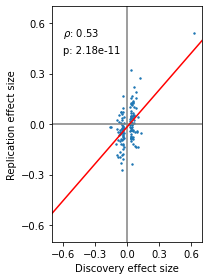

In [31]:
from scipy.stats import t as ttest
from matplotlib import pyplot as plt
import numpy as np

betas_ukbb = df_fe['ukbb_beta']
betas = df_fe['beta1']

fig = plt.figure(figsize=[3.0,4])
ax = fig.add_subplot(111)
plt.scatter(betas_ukbb, betas, s=2)
plt.xlim([-0.7,0.7])
plt.ylim([-0.7,0.7])
ticks=[-0.6,-0.3,0,0.3,0.6]
plt.xticks(ticks)
plt.yticks(ticks)
# ax.set_aspect('equal')
plt.hlines(0,-10,10, colors='gray')
plt.vlines(0,-10,10, colors='gray')
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(np.array(betas_ukbb).reshape(-1,1), betas)
x = [-1,0,1]
y = model.intercept_ + model.coef_ * x
plt.plot(x,y,c='red')
plt.text(-0.6, 0.52,'$\\rho$: ' + str(np.round(np.corrcoef(betas_ukbb, betas)[0,1],2)))
r = np.corrcoef(betas_ukbb, betas)[0,1]
t = r * np.sqrt(len(betas) - 2) / np.sqrt(1 - r**2)
print(t)
plt.text(-0.6, 0.42,'p: ' + str(np.format_float_scientific(ttest.sf(t, len(betas)-2), 2))) # univariate t-test, as we know slope>=0

#plt.title('Lead SNP effect size correlation', fontweight='bold')
plt.xlabel('Discovery effect size')
plt.ylabel('Replication effect size')
# plt.grid()

plt.tight_layout()
plt.savefig("/Users/mbeyele5/retina_tortuosity/output/GWAS_all/skipogh_DF_GWAS_Tanguy/fe_beta_correlation.tiff")
plt.savefig("/Users/mbeyele5/retina_tortuosity/output/GWAS_all/skipogh_DF_GWAS_Tanguy/fe_beta_correlation.png")



### Binomial test for 2e

In [32]:
from scipy.stats import binom

print("Number of SNPs tested:", len(betas_ukbb))

same_sign = [True for idx,i in enumerate(betas_ukbb) if i*betas[idx]>0]
print("Number of same-side effects:", len(same_sign))

N_binom=136
k_binom=90
p_binom=0.5

print("Probability of getting at least k_binom out of N_binom same-side effects out of a random draw with p_binom chance:")
np.format_float_scientific(1 - binom.cdf(k_binom, N_binom, p_binom), 2)

Number of SNPs tested: 136
Number of same-side effects: 90
Probability of getting at least k_binom out of N_binom same-side effects out of a random draw with p_binom chance:


'4.95e-05'

## Suppl. Fig. 4 (removing outliers)
Same figure, but without the one SNP with huge effect

4.382603300887685


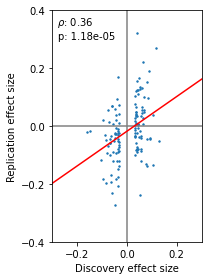

In [33]:
from scipy.stats import t as ttest
from matplotlib import pyplot as plt
import numpy as np

i_max = np.argmax(np.asarray(df_fe['ukbb_beta']))

betas_ukbb = list(df_fe['ukbb_beta'])
betas = list(df_fe['beta1'])

# censoring
del betas_ukbb[i_max]
del betas[i_max]


fig = plt.figure(figsize=[3.0,4])
ax = fig.add_subplot(111)
plt.scatter(betas_ukbb, betas, s=2)
plt.xlim([-0.3,0.3])
plt.ylim([-0.4,0.4])
ticks=[-0.4,-0.2,0,0.2,0.4]
# plt.xticks(ticks)
plt.yticks(ticks)
# ax.set_aspect('equal')
plt.hlines(0,-10,10, colors='gray')
plt.vlines(0,-10,10, colors='gray')
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(np.array(betas_ukbb).reshape(-1,1), betas)
x = [-1,0,1]
y = model.intercept_ + model.coef_ * x
plt.plot(x,y,c='red')
plt.text(-0.28, 0.35,'$\\rho$: ' + str(np.round(np.corrcoef(betas_ukbb, betas)[0,1],2)))
r = np.corrcoef(betas_ukbb, betas)[0,1]
t = r * np.sqrt(len(betas) - 2) / np.sqrt(1 - r**2)
print(t)
plt.text(-0.276, 0.3,'p: ' + str(np.format_float_scientific(ttest.sf(t, len(betas)-2), 2))) # univariate t-test, as we know slope>=0

#plt.title('Lead SNP effect size correlation', fontweight='bold')
plt.xlabel('Discovery effect size')
plt.ylabel('Replication effect size')
# plt.grid()

plt.tight_layout()
plt.savefig("/Users/mbeyele5/retina_tortuosity/output/GWAS_all/skipogh_DF_GWAS_Tanguy/fe_beta_correlation_without_outlier.png")


### Binomial test for Suppl. Fig. 4

In [34]:
from scipy.stats import binom

print("Number of SNPs tested:", len(betas_ukbb))

same_sign = [True for idx,i in enumerate(betas_ukbb) if i*betas[idx]>0]
print("Number of same-side effects:", len(same_sign))

N_binom=130
k_binom=90
p_binom=0.5

print("Probability of getting at least k_binom out of N_binom same-side effects out of a random draw with p_binom chance:")
np.format_float_scientific(1 - binom.cdf(k_binom, N_binom, p_binom), 2)

Number of SNPs tested: 135
Number of same-side effects: 89
Probability of getting at least k_binom out of N_binom same-side effects out of a random draw with p_binom chance:


'2.94e-06'

### Note to self
**Significance of correlation vs significance of regression slope**

For both the uncensored, as well as the censored version of this plot, the significance of the regression slope equaled the significance of the regression!

$ t(df) = \frac { r \times \sqrt{df} } { \sqrt{1 - r^2} } <=> t(df) = \frac {\beta} { SE_\beta } $ 

where $ df = len(betas) - 2 $ 

(I did regression in R, using `model = lm(betas~betas_ukbb`, and `summary(model)` to display the results. I devided the resulting p-values by 2 because R displays two-tailed p-values.)

Conclusion: They must be equivalent in simple linear regression. Maybe I can prove it.

## 2e) SNP-level Benjamini Hochberg
Data based on fixed-effects meta-analysis

Replicated hits: ['rs2571461', 'rs10788873', 'rs35252676', 'rs501943']
Their ranks: [6, 11, 14, 28]


<ipython-input-35-51536df6b2f7>:18: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(hit, (x[i],-np.log10(y[i])), textcoords='offset points',arrowprops=dict(arrowstyle="->"))


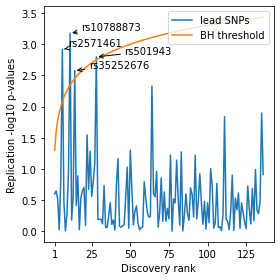

In [35]:
from matplotlib import pyplot as plt
import numpy as np
plt.figure(figsize=[4,4])
plt.plot(range(1,df_fe.shape[0]+1),-np.log10(df_fe['P']))
plt.plot(range(1,df_fe.shape[0]+1), -np.log10(0.05/np.linspace(1, df_fe.shape[0]+1, num=df_fe.shape[0])))
# plt.title("SNP hits", fontweight='bold')
plt.xlabel("Discovery rank")
plt.ylabel("Replication -log10 p-values")
plt.legend(["lead SNPs", "BH threshold"], loc='upper right')
plt.xticks([1,25,50,75,100,125])
# plt.grid()

x,y,txt=get_annotations(df_fe,'P')
print("Replicated hits:", txt)
print("Their ranks:", x)

for i,hit in enumerate(txt):
    plt.annotate(hit, (x[i],-np.log10(y[i])), textcoords='offset points',arrowprops=dict(arrowstyle="->"))

plt.tight_layout()
plt.savefig("/Users/mbeyele5/retina_tortuosity/output/GWAS_all/skipogh_DF_GWAS_Tanguy/fe_SNP_hits.tiff")

# Figure 3
All data based on fixed-effects meta-analysis
## Figure 3e: Rank correlation of discovered genes
Correlating PascalX p-values (gene scores) by transfoming significant genes from discovery using rbINT, and then correlating them using Pearson correlation.

2.1409891604484033


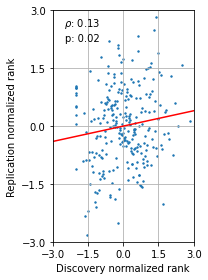

In [36]:
# gene hits that have scores in the meta-analysis
fe_intersect_gene_hits = [i for i in gene_hits if i in fe_geneScores.index]

fe_hits_INT = rank_INT(fe_geneScores[1].loc[fe_intersect_gene_hits])
ukbb_hits_INT = rank_INT(ukbb_geneScores[1].loc[fe_intersect_gene_hits])

fig = plt.figure(figsize=[3.0,4])
ax = fig.add_subplot(111)
plt.scatter(ukbb_hits_INT, fe_hits_INT, s=2)
plt.xlim([-3,3])
plt.ylim([-3,3])
ticks=[-3,-1.5,0,1.5,3]
plt.xticks(ticks)
plt.yticks(ticks)
# ax.set_aspect('equal')
# plt.hlines(0,-10,10, colors='gray')
# plt.vlines(0,-10,10, colors='gray')
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(np.array(ukbb_hits_INT).reshape(-1,1), fe_hits_INT)
x = [-3,0,3]
y = model.intercept_ + model.coef_ * x
plt.plot(x,y,c='red')
plt.text(-2.5, 2.6,'$\\rho$: ' + str(np.round(np.corrcoef(ukbb_hits_INT, fe_hits_INT)[0,1],2)))
r = np.corrcoef(ukbb_hits_INT, fe_hits_INT)[0,1]
t = r * np.sqrt(len(ukbb_hits_INT) - 2) / np.sqrt(1 - r**2)
print(t) # t: 4.94, df: N -2 , univariate
plt.text(-2.48, 2.2,'p: ' + str(np.round(ttest.sf(t, len(ukbb_hits_INT)-2), 2))) # t test

#plt.title('Lead SNP effect size correlation', fontweight='bold')
plt.xlabel('Discovery normalized rank')
plt.ylabel('Replication normalized rank')
plt.grid()
plt.tight_layout()

plt.savefig("/Users/mbeyele5/retina_tortuosity/output/GWAS_all/skipogh_DF_GWAS_Tanguy/fe_geneScore_rankCorrelation.tiff")

## Figure 3e: Gene-level Benjamini-Hochberg replication
All data are based on fixed-effects meta-analysis.

<ipython-input-40-387307e429b0>:17: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(hit, (x[i+1],-np.log10(y[i+1])), textcoords='offset points',arrowprops=dict(arrowstyle="->"))


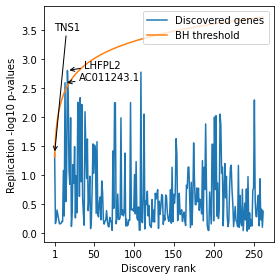

In [40]:
from matplotlib import pyplot as plt
import numpy as np
dfp=fe_geneScores.loc[fe_intersect_gene_hits]
plt.figure(figsize=[4,4])
plt.plot(range(1,dfp.shape[0]+1),-np.log10(dfp[1]))
plt.plot(range(1,dfp.shape[0]+1), -np.log10(0.05/np.linspace(1, dfp.shape[0]+1, num=dfp.shape[0])))
# plt.title("Gene hits", fontweight='bold')
plt.xlabel("Discovery rank")
plt.xticks([1,50,100,150,200,250])
plt.ylabel("Replication -log10 p-values")
plt.legend(["Discovered genes", "BH threshold"], loc='upper right')

x,y,txt=get_annotations(dfp,1)

plt.annotate(txt[0], (x[0],-np.log10(y[0])), xytext=(0,3.5), arrowprops=dict(arrowstyle="->"))
for i,hit in enumerate(txt[1:3]):
    plt.annotate(hit, (x[i+1],-np.log10(y[i+1])), textcoords='offset points',arrowprops=dict(arrowstyle="->"))

plt.tight_layout()
plt.savefig("/Users/mbeyele5/retina_tortuosity/output/GWAS_all/skipogh_DF_GWAS_Tanguy/fe_gene_hits.tiff")

# Supplementary Figure 5
Pathway-level BH was not included in the main text.

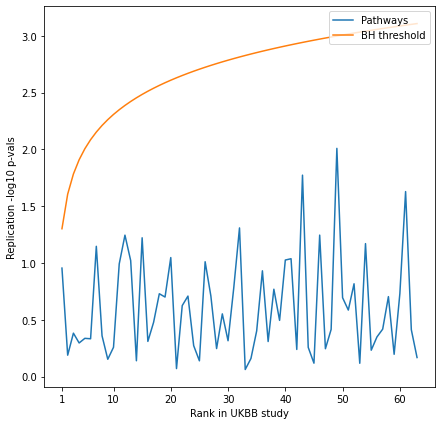

In [38]:
from matplotlib import pyplot as plt
import numpy as np
dfp=fe_ptwSc
plt.figure(figsize=[7,7])
plt.plot(range(1,dfp.shape[0]+1),-np.log10(dfp[3]))
plt.plot(range(1,dfp.shape[0]+1), -np.log10(0.05/np.linspace(1, dfp.shape[0]+1, num=dfp.shape[0])))
# plt.title("Fixed-effects metaanalysis", fontweight='bold', size=15)
plt.xlabel("Rank in UKBB study")
plt.ylabel("Replication -log10 p-vals")
plt.xticks([1,10,20,30,40,50,60])
plt.legend(["Pathways", "BH threshold"], loc='upper right')

x,y,txt=get_annotations(dfp,3)

for i,hit in enumerate(txt):
    plt.annotate(hit, (x[i],-np.log10(y[i])), textcoords='offset points',arrowprops=dict(arrowstyle="->"))

plt.savefig("/Users/mbeyele5/retina_tortuosity/output/GWAS_all/skipogh_DF_GWAS_Tanguy/fe_ptw_hits.png")

# Supplementary Figure 6
This figure summarizes the equivalent results, but based on the mixed-effects meta-analysis.

<ipython-input-39-6e25ff3a1df7>:20: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax1.annotate(hit, (x[i],-np.log10(y[i])), textcoords='offset points',arrowprops=dict(arrowstyle="->"))


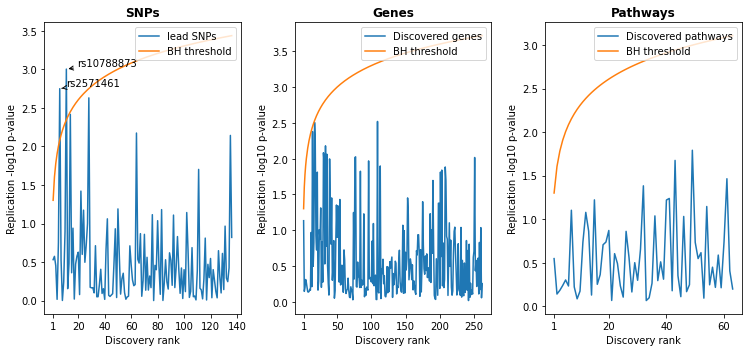

In [39]:
f=plt.figure(figsize=(10.5,5))
# f.suptitle('Mixed-effects meta-analysis', fontweight='bold', fontsize=16)

# SNPs

ax1 = plt.subplot(1,3,1)

# plt.figure(figsize=[5,5])
ax1.plot(range(1,df_me.shape[0]+1),-np.log10(df_me['P']))
ax1.plot(range(1,df_me.shape[0]+1), -np.log10(0.05/np.linspace(1, df_me.shape[0]+1, num=df_me.shape[0])))
ax1.set_xticks([1,20,40,60,80,100,120,140])
ax1.set_title("SNPs", fontweight='bold')
ax1.set_xlabel("Discovery rank")
ax1.set_ylabel("Replication -log10 p-value")
plt.legend(["lead SNPs", "BH threshold"], loc='upper right')

x,y,txt=get_annotations(df_me,'P')

for i,hit in enumerate(txt):
    ax1.annotate(hit, (x[i],-np.log10(y[i])), textcoords='offset points',arrowprops=dict(arrowstyle="->"))

# Genes

ax2 = plt.subplot(1,3,2)

me_intersect_gene_hits = [i for i in gene_hits if i in me_geneScores.index]

dfp=me_geneScores.loc[me_intersect_gene_hits]
ax2.plot(range(1,dfp.shape[0]+1),-np.log10(dfp[1]))
ax2.plot(range(1,dfp.shape[0]+1), -np.log10(0.05/np.linspace(1, dfp.shape[0]+1, num=dfp.shape[0])))
ax2.set_xticks([1,50,100,150,200,250])
ax2.set_title("Genes", fontweight='bold')
ax2.set_xlabel("Discovery rank")
ax2.set_ylabel("Replication -log10 p-value")
plt.legend(["Discovered genes", "BH threshold"], loc='upper right')

x,y,txt=get_annotations(dfp,1)

for i,hit in enumerate(txt):
    ax2.annotate(hit, (x[i],-np.log10(y[i])), textcoords='offset points',arrowprops=dict(arrowstyle="->"))

# Pathways

ax3 = plt.subplot(1,3,3)

dfp=me_ptwSc
ax3.plot(range(1,dfp.shape[0]+1),-np.log10(dfp[3]))
ax3.plot(range(1,dfp.shape[0]+1), -np.log10(0.05/np.linspace(1, dfp.shape[0]+1, num=dfp.shape[0])))
ax3.set_xticks([1,20,40,60])
ax3.set_title("Pathways", fontweight='bold')
ax3.set_xlabel("Discovery rank")
ax3.set_ylabel("Replication -log10 p-value")
plt.legend(["Discovered pathways", "BH threshold"], loc='upper right')

x,y,txt=get_annotations(dfp,3)

for i,hit in enumerate(txt):
    ax3.annotate(hit, (x[i],-np.log10(y[i])), textcoords='offset points',arrowprops=dict(arrowstyle="->"))

# Save figure

plt.tight_layout()
plt.savefig("/Users/mbeyele5/retina_tortuosity/output/GWAS_all/skipogh_DF_GWAS_Tanguy/me_SupplFig6.png")

# Unused figures